# Lid-driven Cavity Flow using the Projection Method

## Introduction 

Consider the 2D incompressible Navier-Stokes equations (also known as momentum equations)

\begin{align}
& \frac{\partial u}{\partial t}+u \cdot \frac{\partial u}{\partial x}+v \cdot \frac{\partial u}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial x}+\nu \frac{\partial^2 u}{\partial x^2}+\nu \frac{\partial^2 u}{\partial y^2}, \\
& \frac{\partial v}{\partial t}+u \cdot \frac{\partial v}{\partial x}+v \cdot \frac{\partial v}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial y}+\nu \frac{\partial^2 v}{\partial x^2}+\nu \frac{\partial^2 v}{\partial y^2},
\end{align}

and the continuity equation

\begin{equation}
\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}=0,
\end{equation}

where $\mathbf{u} = (u,v)$ are flow velocities  in $x,y$ direction, $\rho$ is the density (constant for incompressible flow), $\nu$ is the kinematic viscosity, and $p$ stands for pressure.
One can write them into a more compact form (dimension free) as 

\begin{align}
\frac{\partial \mathbf{u}}{\partial t}+(\mathbf{u} \cdot \nabla) \mathbf{u}&= -\frac{1}{\rho} \nabla p+\nu \nabla^2 \mathbf{u}, \\
\nabla \cdot \mathbf{u} & =0.
\end{align}

---

### Staggered Grid

To deal with the checkerboard pressure problem, we assign different mesh systems to each primitive  variables $u,v,p$ as following.


<p align="center">
  <a href="https://www.cfd-online.com/Wiki/Staggered_grid">
    <img width=50% src="./Gallery/staggered_grid.png">
  </a>
</p>

The pressure is stored at the cell center and the velocities are stored at the cell faces.

---

### Chorin's Projection Method

The algorithm adopts an operator splitting approach in which one considers the viscous forces (in the first half step) and the pressure forces (in the second half step) separately. A distinguishing feature of Chorin's projection method is that the velocity field is forced to satisfy a discrete continuity constraint at the end of each time step.

We first discretize the time domain using an explicit Euler scheme

\begin{equation}
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}=-\frac{1}{\rho} \nabla p^{n+1}-\left(\mathbf{u}^n \cdot \nabla\right) +\nu \nabla^2 \mathbf{u}^n,
\end{equation}

where the time-step $\Delta t$ should be chosen so that $u \Delta t / \Delta x<1$ to satisfy the Courant-Friedrichs-Lewy (CFL) condition.

**Step I: Predictor step** \
Computes an intermediate velocity ${\mathbf  {u}}^{*}$, explicitly using the momentum equation by ignoring the pressure gradient term $\nabla p^{n+1} = 0$:

\begin{align}
\frac{\mathbf{u}^*-\mathbf{u}^n}{\Delta t} = -\left(\mathbf{u}^n \cdot \nabla\right) \mathbf{u}^n+\nu \nabla^2 \mathbf{u}^n, 
\end{align}

where $\mathbf{u}^n$ is the velocity at $n^{\text {th }}$ time step. 

**Step II: Projection step** \
We correct the intermediate velocity to obtain the final solution of the time step $\mathbf{u}^{n+1}$ 

\begin{equation}
\frac{\mathbf{u}^{n+1}-\mathbf{u}^*}{\Delta t}=-\frac{1}{\rho} \nabla p^{n+1}.
\end{equation}

**Step III: Pressure Poisson equation** \
Considering the divergence (continuity) condition at the next time step $t=n+1$, we have

\begin{align}
\nabla \cdot \mathbf{u}^{n+1} = 0
\quad \Rightarrow \quad
\nabla \cdot \bigg(\mathbf{u}^*-\frac{\Delta t}{\rho} \nabla p^{n+1} \bigg) = 0.
\end{align}

Reorganize it to obtain a Poisson problem

\begin{align}
\boxed{\nabla^2 p^{n+1}=\frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*.}
\end{align}

**Step IV: Velocity correction** \
Once we solve the Poisson problem, we can correct the velocity from ${\mathbf  {u}}^{*}$ to the next time step $\mathbf{u}^{n+1}$ 
\begin{align}
\mathbf{u}^{n+1}=\mathbf{u}^*-\frac{\Delta t}{\rho} \nabla p^{n+1}.
\end{align}

---

## Algorithm

The code below follows this guide https://www.montana.edu/mowkes/research/source-codes/GuideToCFD.pdf


In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import sparse
from qiskit.circuit.library import TwoLocal,RealAmplitudes
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.eigensolvers import NumPyEigensolver
from qiskit_aer.primitives import Estimator as Aer_Estimator
from qiskit_aer.primitives import Sampler as Aer_Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile, QuantumCircuit
from qiskit_algorithms.optimizers import *
from qiskit.quantum_info.operators import Operator, SparsePauliOp
import time
import dill as pickle
import sys
import pentapy as pp

ipython_vars = ["In", "Out", "exit", "quit", "get_ipython", "ipython_vars"]
mem_stats = {}
time_stats = {}
solver = 'sparse'
res_tol = 1e-4
for size in range(3,4):
    Lx = 1              # length of domian in x-direction
    Ly = 1              # length of domian in y-direction
    n = size             # Half the number of qubits
    nx = 2**n            # grid size in x-direction. Fixed to be in terms of number of qubits
    ny = 2**n            # grid size in y-direction. Fixed to be in terms of number of qubits and square
    quantum = True
    q_method = "Global"
    Re = 100            # Reynolds number
    nu = 1/Re           # kinematic viscosity
    rho = 1.0           # density
    dt = 0.1          # time step size. MADE THIS BIG FOR TESTING
    itr = 1000         # iterations
    
    # Create staggered grid index system
    imin, jmin = 1, 1
    imax = imin + nx - 1
    jmax = jmin + ny - 1
    
    # Define ghost cells for boundary conditions
    x = np.zeros(jmax + 2)
    y = np.zeros(jmax + 2)
    x[imin: imax + 2] = np.linspace(0, Lx, nx + 1, endpoint=True)
    y[jmin: jmax + 2] = np.linspace(0, Ly, ny + 1, endpoint=True)
    
    dx = x[imin + 1] - x[imin]
    dy = y[jmin + 1] - y[jmin]
    dxi = 1 / dx
    dyi = 1 / dy
    
    # Variable declaration
    u = np.zeros((imax + 2, jmax + 2))
    v = np.zeros((imax + 2, jmax + 2))
    def calculate_laplace_three_point(bound1,bound2,size):
         
        main_diag = 2.0 * np.ones(size)
        main_diag[0] = bound1
        main_diag[-1]= bound2
        off_diag  =  -1.0 * np.ones(size-1)
        laplace_term = sparse.diags([main_diag, off_diag, off_diag], (0, -1, 1))
        return laplace_term
    
    def form_two_d_poisson():
        spx = sparse.kron(sparse.eye(nx),calculate_laplace_three_point(1,1,ny),format='csr')
        spy = sparse.kron(calculate_laplace_three_point(1,1,nx),sparse.eye(ny),format='csr')
        return spx+spy
    def Laplacian(nx, ny):
        Dx = np.diag(np.ones(nx)) * 2 - np.diag(np.ones(nx - 1), 1) - np.diag(np.ones(nx - 1), -1)
        Dx[0, 0] = 1
        Dx[-1, -1] = 1
        Ix = np.diag(np.ones(ny))
        Dy = np.diag(np.ones(ny)) * 2 - np.diag(np.ones(ny - 1), 1) - np.diag(np.ones(ny - 1), -1)
        Dy[0, 0] = 1
        Dy[-1, -1] = 1
        Iy = np.diag(np.ones(nx))
        L = sparse.kron(Ix, Dx,format='csr') + sparse.kron(Dy, Iy,format='csr')
        return L
    def Laplacian_d(nx, ny):
        Dx = np.diag(np.ones(nx)) * 2 - np.diag(np.ones(nx - 1), 1) - np.diag(np.ones(nx - 1), -1)
        Dx[0, 0] = 1
        Dx[-1, -1] = 1
        Ix = np.diag(np.ones(ny))
        Dy = np.diag(np.ones(ny)) * 2 - np.diag(np.ones(ny - 1), 1) - np.diag(np.ones(ny - 1), -1)
        Dy[0, 0] = 1
        Dy[-1, -1] = 1
        Iy = np.diag(np.ones(nx))
        L = np.kron(Ix, Dx) + np.kron(Dy, Iy)
        return L
    def boundary_condition(u, v):
        u[imin, jmin - 1:jmax + 1] = 0
        u[imax + 1, jmin - 1:jmax + 1] = 0
        u[imin: imax + 2, jmin - 1] = -u[imin: imax + 2, jmin]
        u[imin: imax + 2, jmax + 1] = 2 - u[imin: imax + 2, jmax]
    
    
        v[imin - 1: imax + 2, jmin] = 0
        v[imin - 1: imax + 2, jmax + 1] = 0
        v[imin - 1, jmin:jmax + 1] = -v[imin, jmin:jmax + 1]
        v[imax + 1, jmin:jmax + 1] = -v[imax, jmin:jmax + 1]
    def complement_eye(qubit):
        ident1 = np.eye(imax*jmax//2)
        proj = np.array([[1,0],[0,0]])
        if qubit == 0:
            res = np.kron(proj,ident1)
        else:
            ident1 = np.eye(2**qubit)
            ident2 = np.eye(imax*jmax//(2*int(np.sqrt(np.size(ident1)))))
            res = np.kron(np.kron(ident1,proj),ident2)
        return res
    
    #L = form_two_d_poisson()
    if solver in ['sparse', 'random']:
        L = Laplacian(nx,ny)
    else:
        L = Laplacian_d(nx,ny)
    #L = sparse.csc_matrix(L)
    try:
        store_classical
    except:
        store_classical = {}
    try:
        store_quantum
    except:
        store_quantum = {}
    beg = time.time()
    for iteration in range(itr):
        
        # u-momentum
        us = u.copy()
        u_lst = u.copy()
        I = slice(imin + 1, imax + 1)
        Ib = slice(imin, imax)
        If = slice(imin + 2, imax + 2)
    
    
        J = slice(jmin, jmax + 1)
        Jb = slice(jmin - 1, jmax)
        Jf = slice(jmin + 1, jmax + 2)
    
    
        v_here = 0.25 * (v[Ib, J] + v[Ib, Jf] + v[I, J] + v[I, Jf])
        us[I, J] = u[I, J] + dt * (
                nu * (u[Ib, J] - 2 * u[I, J] + u[If, J]) * dxi ** 2
                + nu * (u[I, Jb] - 2 * u[I, J] + u[I, Jf]) * dyi ** 2
                - v_here * (u[I, Jf] - u[I, Jb]) * 0.5 * dyi
                - u[I, J] * (u[If, J] - u[Ib, J]) * 0.5 * dxi
        )
    
    
        # v-momentum
        vs = v.copy()
        v_lst = v.copy()
        I = slice(imin, imax + 1)
        Ib = slice(imin - 1, imax)
        If = slice(imin + 1, imax + 2)
    
    
        J = slice(jmin + 1, jmax + 1)
        Jb = slice(jmin, jmax)
        Jf = slice(jmin + 2, jmax + 2)
    
    
        u_here = 0.25 * (u[I, Jb] + u[I, J] + u[If, Jb] + u[If, J])
        vs[I, J] = v[I, J] + dt * (
                nu * (v[Ib, J] - 2 * v[I, J] + v[If, J]) * dxi ** 2
                + nu * (v[I, Jb] - 2 * v[I, J] + v[I, Jf]) * dyi ** 2
                - u_here * (v[If, J] - v[Ib, J]) * 0.5 * dxi
                - v[I, J] * (v[I, Jf] - v[I, Jb]) * 0.5 * dyi
        )
    
        # Claculate R.H.S of pressure Poisson
        Rn = -rho / dt * ((us[imin + 1: imax + 2, jmin: jmax + 1]
                           - us[imin: imax + 1, jmin: jmax + 1]) * dx
                          + (vs[imin: imax + 1, jmin + 1: jmax + 2]
                           - vs[imin: imax + 1, jmin: jmax + 1]) * dy)  
        R = Rn.T.ravel()
        R_sparse = sparse.lil_matrix(R).T
        if quantum:
            if not R.any():
                pv = np.zeros(nx*ny)
                q_solve = False
            else:
                b = R/np.linalg.norm(R)
                q_solve = True
            #def pressure_correct_quantum(imax, jmax, rhsp, Ap, p, alpha):
            if q_solve:
                outer_b = np.outer(b,b)
                num_qubits = 2*n
                prep_circ = QuantumCircuit(num_qubits)
                for qubit in range(num_qubits):
                    prep_circ.h(qubit)
                if q_method == "Global":
                    H_test = L.T @ (np.eye(nx*ny)-outer_b) @ L
                    m_op = Operator(H_test)
                elif q_method == "Local":
                    qc = QuantumCircuit(num_qubits)
                    qc.initialize(b,normalize=True)
                    U = Operator(transpile(qc,basis_gates=['u','cx'],optimization_level=3))
                    sum_piece =  np.zeros((nx*ny,nx*ny))
                    for q in range(num_qubits):
                        sum_piece += complement_eye(q)
                    H_test2 = L.T.conj() @ U @ (np.eye(nx*ny) - 1/(num_qubits) * sum_piece) @ U.data.T.conj() @ L
                    m_op = Operator(H_test2)
                else:
                    raise ValueError("Quantum method not supported. Should be 'Local' or 'Global'")
                # sp_op_grouped = SparsePauliOp.from_operator(m_op).group_commuting(qubit_wise=True)
                # Solve pressure correction implicitly and update pressure
                optimizer = L_BFGS_B(maxfun=90000, maxiter=50000, ftol=1e-18,max_evals_grouped=8)
                counts = []
                values = []
                def store_intermediate_result(eval_count, parameters, mean, std):
                        counts.append(eval_count)
                        values.append(mean)
                est = Aer_Estimator(run_options={"shots": None},approximation = True)
                ansatz = RealAmplitudes(num_qubits,reps=3*num_qubits, initial_state=prep_circ)
                if iteration < 2:
                    ip = np.random.rand(ansatz.num_parameters)
                else:
                    ip = result_sim.optimal_point
                eig = 1
                inner_it = 1
                best_eig = 9999
                while eig > 1e-4 and inner_it < 10:
                    vqe = VQE(est,ansatz,optimizer,initial_point=ip)
                    beg = time.time()
                    result_sim = vqe.compute_minimum_eigenvalue(SparsePauliOp.from_operator(m_op))
                    vqe_run = time.time()-beg
                    eig = result_sim.eigenvalue
                    #print("Inner iteration: ",inner_it,"found eigenvalue: ",eig)
                    inner_it += 1
                    if inner_it > 1:
                        ip = np.random.rand(ansatz.num_parameters)
                    if eig < best_eig:
                        result_sim_best = result_sim
                        best_eig = eig
                        vqe_run_best = vqe_run
                
                opt_circ = result_sim_best.optimal_circuit.assign_parameters(result_sim_best.optimal_point)
                opt_circ = transpile(opt_circ,basis_gates=['u','cx'],optimization_level=0)
                opt_circ.save_statevector()     
                backend = AerSimulator(method="statevector")
                vqes = backend.run(opt_circ)
                res = vqes.result()
            
                def rescale_sol(A,p,b):
                    rescale = A @ p
                    nzs2 = np.argmax(np.abs(b))
                    scale_factor = b[nzs2]/rescale[nzs2]
                    return scale_factor
                
                # result_sim = NumPyMinimumEigensolver().compute_minimum_eigenvalue(SparsePauliOp.from_operator(m_op))
                # pv = result_sim.eigenstate.data.real
                pv = res.get_statevector().data.real
                scale = rescale_sol(L,pv,b)
                pv = scale*pv*np.linalg.norm(R)
                print("Iteration: ", iteration,"with VQE duration", vqe_run_best, " found eigenvalue:",result_sim.eigenvalue,
                 "Erorr:",np.max(L @ pv - R ))
                store_quantum.update({iteration:{'p' :pv,'result':result_sim_best}})
            
        else:
            if solver =='sparse':
                pv = sparse.linalg.spsolve(L,R_sparse)
            elif solver =='dense':
                pv = np.linalg.solve(L_dense,R)
            elif solver =='pdiag':
                pv = pp.solve(L_dense,R)
            elif solver =='random':
                pv = np.random.rand(len(R))
            store_classical.update({iteration:(pv,R)})
        pn = pv.reshape(ny, nx).T
        p = np.zeros((imax + 1, jmax + 1))
        p[1:, 1:] = pn
        # Correct velocity
        u[imin + 1: imax + 1, jmin: jmax + 1] = us[imin + 1: imax + 1, jmin: jmax + 1] - dt / rho * (
                    p[imin + 1: imax + 1, jmin: jmax + 1] - p[imin: imax, jmin: jmax + 1]) * dxi
        v[imin: imax + 1, jmin + 1: jmax + 1] = vs[imin: imax + 1, jmin + 1: jmax + 1] - dt / rho * (
                    p[imin: imax + 1, jmin + 1: jmax + 1] - p[imin: imax + 1, jmin: jmax]) * dyi
        
        
        
        boundary_condition(u, v)
        if iteration >0:
            u_res = np.abs(u_lst - u)
            v_res = np.abs(v_lst - v)
            max_res_u = np.max(u_res)
            max_res_v = np.max(v_res)
            max_res = max(max_res_u,max_res_v)
            #Check for convergence  
            if (iteration % 20) == 0:
                print(f"Iteration = {iteration}; Residual = {max_res}")
            if max_res < res_tol:
                break
        mem = {
            key: value
            for key, value in sorted(
                [
                    (x, sys.getsizeof(globals().get(x)))
                    for x in dir()
                    if not x.startswith("_") and x not in sys.modules and x not in ipython_vars
                ],
                key=lambda x: x[1],
                reverse=True,
            )
        }
        mem_usage = sum(mem.values()) / 1e6
    duration = time.time() - beg
    time_stats.update({size:duration})
    mem_stats.update({size:mem_usage})


Iteration:  1 with VQE duration 83.506915807724  found eigenvalue: 1.9452393081736963e-09 Erorr: 9.07444022343884e-06
Iteration:  2 with VQE duration 351.81976222991943  found eigenvalue: -1.4964967358582792e-05 Erorr: 1.6140756745584264e-05
Iteration:  3 with VQE duration 52.04761981964111  found eigenvalue: -2.1302449060981495e-06 Erorr: 8.81641229519281e-06
Iteration:  4 with VQE duration 53.858891010284424  found eigenvalue: -1.1760494338038802e-05 Erorr: 1.2304329327380344e-05
Iteration:  5 with VQE duration 43.65202045440674  found eigenvalue: -3.967393278689682e-06 Erorr: 1.2112512954946201e-05
Iteration:  6 with VQE duration 40.88430380821228  found eigenvalue: -1.4835025702775347e-05 Erorr: 1.6759355768962013e-05
Iteration:  7 with VQE duration 53.597320795059204  found eigenvalue: 8.192906390904788e-06 Erorr: 8.081280260759972e-06
Iteration:  8 with VQE duration 59.15038990974426  found eigenvalue: 1.1332055266474739e-05 Erorr: 7.5858616742417815e-06
Iteration:  9 with VQE du

In [ ]:
#Code in the closed form of the Laplacian to test if it matches the current form

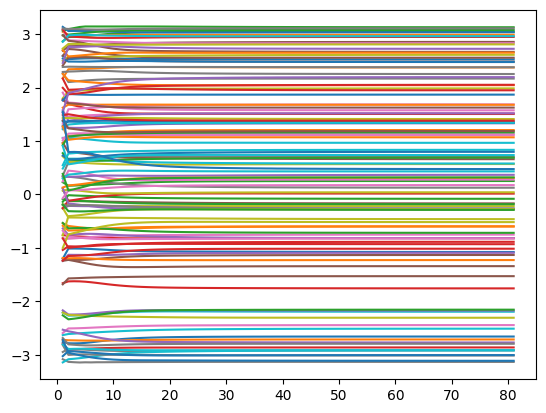

In [4]:
for j in range(len(store_quantum[1]['result'].optimal_point)):
    plt.plot(range(1,len(store_quantum)),[store_quantum[i]['result'].optimal_point[j] for i in range(1,len(store_quantum))])

In [7]:
pickle.dump(mem_stats,open('data/prep_mem_stats.p','wb'))
pickle.dump(time_stats,open('data/prep_time_stats.p','wb'))

In [9]:
# sp_mem = pickle.load(open('data/sparse_mem_stats.p','rb'))
# sp_time = pickle.load(open('data/sparse_time_stats.p','rb'))
# dens_mem = pickle.load(open('data/dense_mem_stats.p','rb'))
# dens_time = pickle.load(open('data/dense_time_stats.p','rb'))
# p_mem = pickle.load(open('data/penta_mem_stats.p','rb'))
# p_time = pickle.load(open('data/penta_time_stats.p','rb'))
# random_mem = pickle.load(open('data/random_mem_stats.p','rb'))
# random_time = pickle.load(open('data/random_time_stats.p','rb'))
prep_mem = pickle.load(open('data/prep_mem_stats.p','rb'))
prep_time = pickle.load(open('data/prep_time_stats.p','rb'))

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

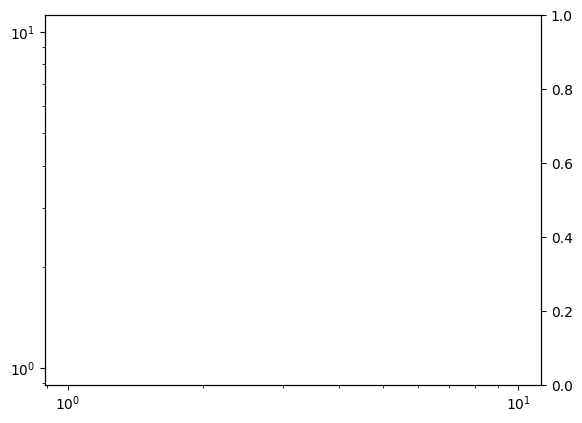

In [10]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

# ax1.loglog([2**(2*i) for i in range(2,7)],dens_time.values(),label='Dense', color = 'b', linestyle='--')
# ax1.loglog([2**(2*i) for i in range(2,7)],sp_time.values(),label='Sparse', color = 'b',linestyle='-.')
# ax1.loglog([2**(2*i) for i in range(2,7)],p_time.values(),label='Penta', color = 'b',linestyle=':')
ax1.loglog([2**(2*i) for i in range(2,7)],prep_time.values(),label='Prep',color='b',linestyle='-')
# ax2.loglog([2**(2*i) for i in range(2,7)],dens_mem.values(),label='Dense',color='r',linestyle='--')
# ax2.loglog([2**(2*i) for i in range(2,7)],sp_mem.values(),label='Sparse',color='r',linestyle='-.')
# ax2.loglog([2**(2*i) for i in range(2,7)],p_mem.values(),label='Penta',color='r',linestyle=':')
ax2.loglog([2**(2*i) for i in range(2,7)],prep_mem.values(),label='Prep',color='r',linestyle='-')

ax1.legend()
ax2.legend()
ax1.set_xlabel("Grid Size")
ax1.set_ylabel("Resource (s)", color = 'b')
ax2.set_ylabel("Memory (MB)", color = 'r')
#ax1.set_ylim([0,100])
#ax2.set_ylim([0,100])

The Laplacian only depends on the computational mesh and can be computed once at the beginning of the simulation and stored.

## Benchmark

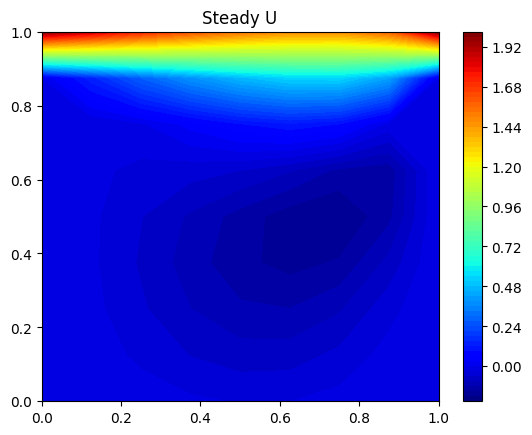

In [11]:
X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u.T, 80, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

In [20]:
GhiaU = np.loadtxt('./Benchmark/GhiaU.txt', skiprows=1)
GhiaV = np.loadtxt('./Benchmark/GhiaV.txt', skiprows=1)
y_Ghia = GhiaU[:, 0]
x_Ghia = GhiaV[:, 0]

In [21]:
# Understand what's inside the benchmark data
import pandas as pd
# pd.set_option('display.max_columns', None)
df = pd.read_table("./Benchmark/GhiaU.txt", skiprows=0, delimiter='\r')
print(df)

   # Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). 
0   # High-Re solutions for incompressible flow us...      
1   # Journal of computational physics, 48(3), 387...      
2                                                   #      
3                                           # TABLE I      
4   # Results for $u$-velocity along Vertical Line...      
5   #---------------------------------------------...      
6              #                                   Re      
7   #       --------------------------------------...      
8   #  y      100      400      1000     3200     ...      
9   #---------------------------------------------...      
10  1.0000  1.00000  1.00000  1.00000  1.00000  1....      
11  0.9766  0.84123  0.75837  0.65928  0.53236  0....      
12  0.9688  0.78871  0.68439  0.57492  0.48296  0....      
13  0.9609  0.73722  0.61756  0.51117  0.46547  0....      
14  0.9531  0.68717  0.55892  0.46604  0.46101  0....      
15  0.8516  0.23151  0.29093  0.33304  0

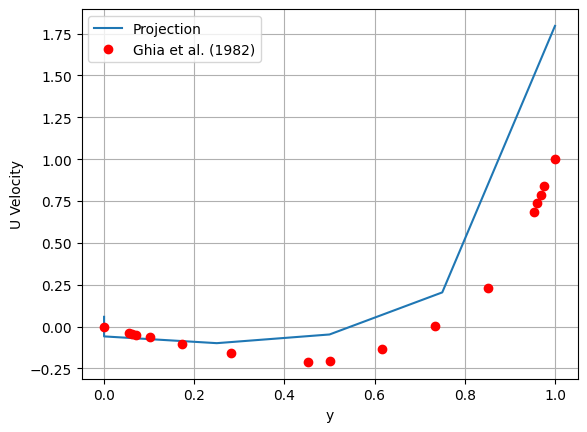

In [22]:
plt.plot(y, u[len(u)//2,:], label="Projection")
plt.plot(y_Ghia, GhiaU[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.legend()